<a href="https://colab.research.google.com/github/shanikairoshi/Communication-Efficient-DUQFL/blob/main/main_DuwithTele_0.13_bestall.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is the latest implementation
This includes;
1. agg
2. clasical and quantum communication
3. teleportaion options

flowchart LR
  %% ----------- Inputs / Config -----------
  A[Start Round t\nConfig:\n• use_deep_unfolding (DU)\n• aggregation ∈ {best, fedavg}\n• uplink_mode ∈ {classical_full, seeded_sparse, quantum}\n• downlink_mode ∈ {classical_full, seeded, quantum}\n• gamma (warm-start)\n• teleport noise, shots]:::cfg

  %% ----------- Broadcast -----------
  A --> B[Server has Global Params w^{t}\n(also prev_broadcast_params = w^{t})]
  B --> C{Downlink mode?}

  C -->|classical_full| C1[[Broadcast full w^{t}]]
  C -->|seeded (seeded mask + scale)| C2[[Send seed & mask\nClients reconstruct ŵ^{t}]]
  C -->|quantum (teleportation)| C3[[Teleport w^{t}\n(θ → θ′ via Bell pair)\nRecord fidelity, β shrink]]

  C1 --> D
  C2 --> D
  C3 --> D

  %% ----------- Local Training -----------
  subgraph S[Each Client i]
    direction TB
    D[Client i receives parameters\nw_i^{t,0} ← w^{t} (reconstructed if seeded/quantum)] --> E[Warm-start LR,PERT:\nLR_i^0 = (1-γ)LR_init + γLR_i^{t-1}\nPERT_i^0 = (1-γ)PERT_init + γPERT_i^{t-1}]
    E --> F{use_deep_unfolding?}
    F -->|Yes| G[Repeat k steps:\nfit → meta-update {LR,PERT}\nclip to trust region\nset w_i^{t,k}]
    F -->|No| H[Single fit with fixed LR, PERT\nset w_i^{t,1}]
    G --> I[Compute metrics (train/test acc,\nclient size, objective)]
    H --> I
    I --> J{Uplink mode?}
    J -->|classical_full| J1[[Send full weights w_i^{t,*}]]
    J -->|seeded_sparse| J2[[Send seeded sparse Δ_i\n(quantized top-k wrt anchor)]]
    J -->|quantum| J3[[Teleport Δ_i or w_i^{t,*}\n(log fidelity)]]
  end

  %% ----------- Aggregation -----------
  J1 --> K
  J2 --> K
  J3 --> K

  K{Aggregation?} -->|best\n(validation-gated τ-mix)| K1[[Pick client j = argmin L_val\nIf improve ≥ ε: w^{t+1} ← (1-τ)w^{t} + τ w_j]]
  K -->|fedavg| K2[[Size-weighted average\nw^{t+1} ← Σ (n_i/N) w_i^{t,*}]]

  K1 --> L[Log round metrics:\nacc_global, L_val,\nbytes_up/down, latency,\nfidelity stats, β]
  K2 --> L
  L --> M[Proceed to Round t+1]
  
  classDef cfg fill:#f5f7ff,stroke:#6b7cff,color:#222,stroke-width:1.2px;


In [1]:
# %%capture
!pip install genomic-benchmarks
!pip install qiskit qiskit_machine_learning qiskit_algorithms qiskit-aer




In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import sys
from pathlib import Path
PROJ = Path.cwd() / "tduQFL_Project_QFLvsDUQFL_AggChoice_CommEff_v2"
if str(PROJ) not in sys.path:
    sys.path.insert(0, str(PROJ))
import sys
sys.path.append('/content/drive/MyDrive/Teleportation/tduQFL_Project_QFLvsDUQFL_AggChoice_CommEff_v2/tDuQFL_Project')
# ─── 5. Assemble filenames for each artifact ─────────────────────────────────
drive_root = "/content/drive/MyDrive/Teleportation/tduQFL_Project_QFLvsDUQFL_AggChoice_CommEff_v2/tDuQFL_Project/"

In [4]:

#from configs.dataset_genome_noniid.py import *     # swap to other configs as needed

In [5]:
from common.imports import *
from configs.dataset_genome import *     # swap to other configs as needed
from io_utils.naming import stamp_now, build_param_str, make_filenames

# main.py or notebook cell
from configs.base_config import *
from io_utils.naming import build_param_str, stamp_now, make_filenames


stamp, date_str = stamp_now()

best_client_csv_file, global_csv_file, local_csv_file, validation_csv_file = make_filenames(
    drive_root=drive_root,
    dataset_name=dataset_name,
    split_type=split_type,
    date_str=date_str,
    aggregation=aggregation,
    select_upload=select_upload,
    use_deep_unfolding=use_deep_unfolding,
    gamma=gamma,
    uplink_mode=uplink_mode,
    downlink_mode=downlink_mode,
    up_k_ratio=up_k_ratio,
    up_bits=up_bits,
    down_mask_ratio=down_mask_ratio,
    down_scale=down_scale,
    noise_preset=noise_preset,
    shots_used=shots_used,

)
print(best_client_csv_file)
print(global_csv_file)
print(local_csv_file)
print(validation_csv_file)

from io_utils.csv_logger import init_local_csv, init_best_csv, init_validation_csv

# Create folders + write headers
init_best_csv(best_client_csv_file)

local_headers = [
    "Federated Round", "Client Number", "Iteration",
    "Objective Function Value", "Training Accuracy", "Test Accuracy",
    "Learning Rate", "Perturbation"
]
init_local_csv(local_csv_file, local_headers)

init_validation_csv(validation_csv_file)

# Do NOT pre-init global_csv_file here because your save_accuracies_to_csv()
# already writes the header each time it runs (in 'w' mode).

/usr/local/lib/python3.12/dist-packages/genomic_benchmarks/utils/datasets.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
Qiskit: 1.4.5
qiskit_aer available?: True
/content/drive/MyDrive/Teleportation/tduQFL_Project_QFLvsDUQFL_AggChoice_CommEff_v2/tDuQFL_Project/Results/quantumCommunication/genome/DuwithTele_0.13_bestall/tDuQFL_Genome_NONIID_AGG-best_SU-all_DU-on_g0p5_UL-quantum__DL-quantum_Q-on_med_shots256_14_10_2025_Best_Client.csv
/content/drive/MyDrive/Teleportation/tduQFL_Project_QFLvsDUQFL_AggChoice_CommEff_v2/tDuQFL_Project/Results/quantumCommunication/genome/DuwithTele_0.13_bestall/tDuQFL_Genome_NONIID_AGG-best_SU-all_DU-on_g0p5_UL-quantum__DL-quantum_Q-on_med_shots256_14_10_2025_Global.csv
/content/drive/MyDrive/Teleportation/tduQFL_Project_QFLvsDUQFL_AggChoice_CommEff_v2/tDuQFL_Project/Results/quantumCommunication/genome/DuwithTele_0.13_bestall/tDuQFL_Genome_NONIID_AGG-best_SU-all_DU-on_g0p5_UL-quantum__DL-qua

Load and Split data

run federated loop and plot

In [6]:
from training.loop import run_federated_training
from configs.base_config import use_teleportation as CFG_TEL, noise_preset, shots_used
from training.metrics import metrics_init, metrics_log_round, metrics_finalize, compute_auc,metrics_summarize
from viz.plots import plot_accuracy_curve, plot_val_loss, plot_time_per_round, plot_fidelity_vs_delta_acc, plot_beta_hist, plot_client_fairness_last_round
# Initialize metrics store once
metrics_store = metrics_init(
    log_path=os.path.join(drive_root, "teleport_metrics_Perturb_shrink.csv")
)

#new
from ml import optimizers as mlopt
from configs.base_config import drive_root
import os

mlopt.meta_trace_enable(
    path=os.path.join(drive_root, "meta_trace.csv"),  # or None to skip CSV
    every=5                                           # print every 5 callbacks
)

# examples/run_switch.py
from configs.base_config import *
from training.data_factory import build_clients_and_meta
from training.loop import run_federated_training
from training.metrics import metrics_init
import os, numpy as np

param_str = build_param_str(
    num_clients,
    num_federated_layers,
    num_deep_unfolding_iterations,
    initial_learning_rate,
    initial_perturbation,
)


# 1) Build clients + meta from config
clients, test_sequences, test_labels, num_features = build_clients_and_meta(
    dataset_name=dataset_name,
    split_type=split_type,
    num_clients=num_clients,
    num_epochs=num_epochs,
    samples_per_epoch=samples_per_epoch,
    word_size=word_size,
    global_seed=global_seed,
    mnist_n_features=mnist_n_features,
    mnist_digit_a=mnist_digit_a,
    mnist_digit_b=mnist_digit_b,
    breast_pca_n_features=breast_pca_n_features,
    non_iid_ratio=non_iid_ratio,
    quantity_variation=quantity_variation,
    noniid_seed=noniid_seed,
)

# 2) Validation set (use test as val if you don’t have a separate split)
X_val, y_val = test_sequences, test_labels

# 3) Outputs
os.makedirs(drive_root, exist_ok=True)


metrics = metrics_init(log_path=os.path.join(drive_root, "round_metrics.csv"))

# 4) Train
global_acc, clients_train, clients_test, round_times, val_losses, info_last = run_federated_training(
    clients=clients,
    num_federated_layers=num_federated_layers,
    num_deep_unfolding_iterations=num_deep_unfolding_iterations,
    initial_learning_rate=initial_learning_rate,
    initial_perturbation=initial_perturbation,
    num_features=num_features,
    best_client_csv_file=best_client_csv_file,
    global_csv_file=global_csv_file,
    local_csv_file=local_csv_file,
    validation_csv_file=validation_csv_file,
    test_sequences=test_sequences, test_labels=test_labels,
    X_val=X_val,
    y_val=y_val,
    metrics=metrics,
    aggregation=aggregation,                  # "best" or "fedavg"
    select_upload=select_upload,              # "all" or "winner_only" (used for best)
    use_deep_unfolding=use_deep_unfolding,    # True/False
    uplink_mode=uplink_mode,                  # "classical_full" | "seeded_sparse" | "quantum"
    downlink_mode=downlink_mode,              # "classical_full" | "seeded" | "quantum"
    down_seed_base=down_seed_base,
    down_scale=down_scale,
    down_mask_ratio=down_mask_ratio,
    up_bits=up_bits,
    up_k_ratio=up_k_ratio,
    use_teleportation_backend=True,
    noise_preset=noise_preset,
    shots_used=shots_used,
    client_hparams_csv_file=os.path.join(drive_root, f"hparams_{dataset_name}_{split_type}_{param_str}.csv"),
)

print("Global accuracy per round:", global_acc)

Training Progress:   0%|          | 0/10 [00:00<?, ?it/s]

[Round 0] Agg=best | Uplink=quantum | Downlink=quantum
[meta] cb#005 loss=0.632887 step=0.05055 g_raw=+0.024 g_sm=+0.005 acc=1 | LR→0.120240 PERT→0.120000 (scale=0.04)
[meta] cb#010 loss=0.612813 step=0.009564 g_raw=+0.006 g_sm=+0.012 acc=1 | LR→0.120481 PERT→0.120000 (scale=0.04)
[meta] cb#015 loss=0.601964 step=0.09064 g_raw=+0.041 g_sm=+0.016 acc=1 | LR→0.120723 PERT→0.120001 (scale=0.04)
[meta] cb#020 loss=0.561145 step=0.1557 g_raw=+0.078 g_sm=+0.025 acc=1 | LR→0.120965 PERT→0.120001 (scale=0.04)
[meta] cb#025 loss=0.538462 step=0.04921 g_raw=+0.023 g_sm=+0.028 acc=1 | LR→0.121208 PERT→0.120002 (scale=0.04)
[client 0 | unfold 1] LR 0.120000->0.121208, PERT 0.120000->0.120002 | g_raw_mean=+0.036, g_sm_mean=+0.015
[meta] cb#030 loss=0.528579 step=0.06489 g_raw=+0.028 g_sm=+0.027 acc=1 | LR→0.121451 PERT→0.120002 (scale=0.04)
[meta] cb#035 loss=0.498547 step=0.03808 g_raw=+0.018 g_sm=+0.031 acc=1 | LR→0.121695 PERT→0.120003 (scale=0.04)
[meta] cb#040 loss=0.486859 step=0.1348 g_raw=+

Training Progress:  10%|█         | 1/10 [19:00<2:51:05, 1140.65s/it]

[Round   0] acc_g=0.496 (μ=0.507, σ=0.015, FG=0.031) | t=1082.510s, val=0.677 | TEL β=NA, Fid μ=NA, σ=NA, p50=NA, p90=NA | Lat μ=NA, σ=NA, p90=NA | Inst μ=NA, σ=NA | Δ per-dim=NA, ||Δ||₂=NA, max|Δ|=NA | noise=med, shots=256
[Round 0] ↓=5B ↑=25B | (Σ↓=5B, Σ↑=25B)
[Round 1] Agg=best | Uplink=quantum | Downlink=quantum
[meta] cb#005 loss=0.461189 step=0.07697 g_raw=+0.032 g_sm=+0.004 acc=1 | LR→0.123330 PERT→0.120007 (scale=0.04)
[meta] cb#010 loss=0.448090 step=0.1109 g_raw=+0.045 g_sm=+0.009 acc=1 | LR→0.123577 PERT→0.120007 (scale=0.04)
[meta] cb#015 loss=0.445055 step=0.02581 g_raw=+0.011 g_sm=+0.010 acc=1 | LR→0.123825 PERT→0.120008 (scale=0.04)
[meta] cb#020 loss=0.428622 step=0.1127 g_raw=+0.045 g_sm=+0.015 acc=1 | LR→0.124073 PERT→0.120008 (scale=0.04)
[meta] cb#025 loss=0.410125 step=0.05272 g_raw=+0.021 g_sm=+0.019 acc=1 | LR→0.124322 PERT→0.120008 (scale=0.04)
[client 0 | unfold 1] LR 0.123084->0.124322, PERT 0.120007->0.120008 | g_raw_mean=+0.024, g_sm_mean=+0.009
[meta] cb#03

Training Progress:  20%|██        | 2/10 [37:11<2:28:12, 1111.61s/it]

[Round   1] acc_g=0.507 (μ=0.516, σ=0.022, FG=0.046) | t=1031.201s, val=0.668 | TEL β=NA, Fid μ=NA, σ=NA, p50=NA, p90=NA | Lat μ=NA, σ=NA, p90=NA | Inst μ=NA, σ=NA | Δ per-dim=NA, ||Δ||₂=NA, max|Δ|=NA | noise=med, shots=256
[Round 1] ↓=5B ↑=25B | (Σ↓=10B, Σ↑=50B)
[Round 2] Agg=best | Uplink=quantum | Downlink=quantum
[meta] cb#005 loss=0.551211 step=0.06683 g_raw=+0.029 g_sm=+0.005 acc=1 | LR→0.124952 PERT→0.120008 (scale=0.04)
[meta] cb#010 loss=0.544032 step=0.004703 g_raw=+0.002 g_sm=+0.008 acc=1 | LR→0.125202 PERT→0.120008 (scale=0.04)
[meta] cb#015 loss=0.536479 step=0.09569 g_raw=+0.042 g_sm=+0.011 acc=1 | LR→0.125453 PERT→0.120009 (scale=0.04)
[meta] cb#020 loss=0.521801 step=0.0628 g_raw=+0.029 g_sm=+0.015 acc=1 | LR→0.125705 PERT→0.120009 (scale=0.04)
[meta] cb#025 loss=0.509242 step=0.03818 g_raw=+0.014 g_sm=+0.019 acc=1 | LR→0.125957 PERT→0.120009 (scale=0.04)
[client 0 | unfold 1] LR 0.124702->0.125957, PERT 0.120008->0.120009 | g_raw_mean=+0.024, g_sm_mean=+0.010
[meta] cb

Training Progress:  30%|███       | 3/10 [56:39<2:12:39, 1137.05s/it]

[Round   2] acc_g=0.531 (μ=0.512, σ=0.020, FG=0.043) | t=1110.499s, val=0.676 | TEL β=NA, Fid μ=NA, σ=NA, p50=NA, p90=NA | Lat μ=NA, σ=NA, p90=NA | Inst μ=NA, σ=NA | Δ per-dim=NA, ||Δ||₂=NA, max|Δ|=NA | noise=med, shots=256
[Round 2] ↓=5B ↑=25B | (Σ↓=15B, Σ↑=75B)
[Round 3] Agg=best | Uplink=quantum | Downlink=quantum
[meta] cb#005 loss=0.476426 step=0.2053 g_raw=+0.084 g_sm=+0.013 acc=1 | LR→0.125806 PERT→0.120010 (scale=0.04)
[meta] cb#010 loss=0.451429 step=0.05444 g_raw=+0.021 g_sm=+0.019 acc=1 | LR→0.126058 PERT→0.120011 (scale=0.04)
[meta] cb#015 loss=0.435969 step=0.01818 g_raw=+0.007 g_sm=+0.021 acc=1 | LR→0.126311 PERT→0.120011 (scale=0.04)
[meta] cb#020 loss=0.429336 step=0.01467 g_raw=+0.005 g_sm=+0.020 acc=1 | LR→0.126565 PERT→0.120012 (scale=0.04)
[meta] cb#025 loss=0.393520 step=0.1257 g_raw=+0.052 g_sm=+0.026 acc=1 | LR→0.126819 PERT→0.120012 (scale=0.04)
[client 0 | unfold 1] LR 0.125554->0.126819, PERT 0.120010->0.120012 | g_raw_mean=+0.038, g_sm_mean=+0.018
[meta] cb#0

Training Progress:  40%|████      | 4/10 [1:16:04<1:54:49, 1148.31s/it]

[Round   3] acc_g=0.555 (μ=0.510, σ=0.023, FG=0.050) | t=1109.644s, val=0.663 | TEL β=NA, Fid μ=NA, σ=NA, p50=NA, p90=NA | Lat μ=NA, σ=NA, p90=NA | Inst μ=NA, σ=NA | Δ per-dim=NA, ||Δ||₂=NA, max|Δ|=NA | noise=med, shots=256
[Round 3] ↓=5B ↑=25B | (Σ↓=20B, Σ↑=100B)
[Round 4] Agg=best | Uplink=quantum | Downlink=quantum
[meta] cb#005 loss=0.557602 step=0.0112 g_raw=+0.005 g_sm=+0.003 acc=1 | LR→0.126254 PERT→0.120010 (scale=0.04)
[meta] cb#010 loss=0.526019 step=0.02156 g_raw=+0.010 g_sm=+0.010 acc=1 | LR→0.126507 PERT→0.120010 (scale=0.04)
[meta] cb#015 loss=0.502892 step=0.02013 g_raw=+0.009 g_sm=+0.015 acc=1 | LR→0.126760 PERT→0.120011 (scale=0.04)
[meta] cb#020 loss=0.495981 step=0.07258 g_raw=+0.035 g_sm=+0.017 acc=1 | LR→0.127015 PERT→0.120011 (scale=0.04)
[meta] cb#025 loss=0.481326 step=0.07925 g_raw=+0.032 g_sm=+0.019 acc=1 | LR→0.127269 PERT→0.120012 (scale=0.04)
[client 0 | unfold 1] LR 0.126002->0.127269, PERT 0.120010->0.120012 | g_raw_mean=+0.027, g_sm_mean=+0.012
[meta] cb

Training Progress:  50%|█████     | 5/10 [1:33:47<1:33:07, 1117.60s/it]

[Round   4] acc_g=0.483 (μ=0.514, σ=0.016, FG=0.027) | t=1006.484s, val=0.697 | TEL β=NA, Fid μ=NA, σ=NA, p50=NA, p90=NA | Lat μ=NA, σ=NA, p90=NA | Inst μ=NA, σ=NA | Δ per-dim=NA, ||Δ||₂=NA, max|Δ|=NA | noise=med, shots=256
[Round 4] ↓=5B ↑=25B | (Σ↓=25B, Σ↑=125B)
[Round 5] Agg=best | Uplink=quantum | Downlink=quantum
[meta] cb#005 loss=0.541461 step=0.0956 g_raw=+0.043 g_sm=+0.008 acc=1 | LR→0.126491 PERT→0.120011 (scale=0.04)
[meta] cb#010 loss=0.530534 step=0.03113 g_raw=+0.014 g_sm=+0.012 acc=1 | LR→0.126744 PERT→0.120012 (scale=0.04)
[meta] cb#015 loss=0.497630 step=0.1734 g_raw=+0.079 g_sm=+0.020 acc=1 | LR→0.126998 PERT→0.120012 (scale=0.04)
[meta] cb#020 loss=0.462098 step=0.07798 g_raw=+0.029 g_sm=+0.026 acc=1 | LR→0.127253 PERT→0.120013 (scale=0.04)
[meta] cb#025 loss=0.452086 step=0.1259 g_raw=+0.054 g_sm=+0.025 acc=1 | LR→0.127508 PERT→0.120013 (scale=0.04)
[client 0 | unfold 1] LR 0.126238->0.127508, PERT 0.120011->0.120013 | g_raw_mean=+0.035, g_sm_mean=+0.016
[meta] cb#0

Training Progress:  60%|██████    | 6/10 [1:47:26<1:07:43, 1015.83s/it]

[Round   5] acc_g=0.563 (μ=0.549, σ=0.043, FG=0.094) | t=762.271s, val=0.671 | TEL β=NA, Fid μ=NA, σ=NA, p50=NA, p90=NA | Lat μ=NA, σ=NA, p90=NA | Inst μ=NA, σ=NA | Δ per-dim=NA, ||Δ||₂=NA, max|Δ|=NA | noise=med, shots=256
[Round 5] ↓=5B ↑=25B | (Σ↓=30B, Σ↑=150B)
[Round 6] Agg=best | Uplink=quantum | Downlink=quantum
[meta] cb#005 loss=0.420532 step=0.2115 g_raw=+0.082 g_sm=+0.006 acc=1 | LR→0.126615 PERT→0.120012 (scale=0.04)
[meta] cb#010 loss=0.387402 step=0.08166 g_raw=+0.032 g_sm=+0.015 acc=1 | LR→0.126868 PERT→0.120012 (scale=0.04)
[meta] cb#015 loss=0.377735 step=0.02935 g_raw=+0.011 g_sm=+0.016 acc=1 | LR→0.127123 PERT→0.120012 (scale=0.04)
[meta] cb#020 loss=0.369054 step=0.1423 g_raw=+0.055 g_sm=+0.016 acc=1 | LR→0.127378 PERT→0.120013 (scale=0.04)
[meta] cb#025 loss=0.359370 step=0.04174 g_raw=+0.015 g_sm=+0.018 acc=1 | LR→0.127633 PERT→0.120013 (scale=0.04)
[client 0 | unfold 1] LR 0.126362->0.127633, PERT 0.120012->0.120013 | g_raw_mean=+0.026, g_sm_mean=+0.012
[meta] cb#0

Training Progress:  70%|███████   | 7/10 [2:04:51<51:16, 1025.58s/it]  

[Round   6] acc_g=0.755 (μ=0.548, σ=0.053, FG=0.116) | t=990.573s, val=0.626 | TEL β=NA, Fid μ=NA, σ=NA, p50=NA, p90=NA | Lat μ=NA, σ=NA, p90=NA | Inst μ=NA, σ=NA | Δ per-dim=NA, ||Δ||₂=NA, max|Δ|=NA | noise=med, shots=256
[Round 6] ↓=5B ↑=25B | (Σ↓=35B, Σ↑=175B)
[Round 7] Agg=best | Uplink=quantum | Downlink=quantum
[meta] cb#005 loss=0.506195 step=0.1073 g_raw=+0.043 g_sm=+0.004 acc=1 | LR→0.126678 PERT→0.120010 (scale=0.04)
[meta] cb#010 loss=0.496444 step=0.0583 g_raw=+0.027 g_sm=+0.009 acc=1 | LR→0.126932 PERT→0.120010 (scale=0.04)
[meta] cb#015 loss=0.489918 step=0.006181 g_raw=+0.003 g_sm=+0.011 acc=1 | LR→0.127186 PERT→0.120011 (scale=0.04)
[meta] cb#020 loss=0.472388 step=0.06468 g_raw=+0.030 g_sm=+0.015 acc=1 | LR→0.127441 PERT→0.120011 (scale=0.04)
[meta] cb#025 loss=0.448605 step=0.03749 g_raw=+0.015 g_sm=+0.020 acc=1 | LR→0.127697 PERT→0.120012 (scale=0.04)
[client 0 | unfold 1] LR 0.126425->0.127697, PERT 0.120010->0.120012 | g_raw_mean=+0.026, g_sm_mean=+0.011
[meta] cb#

Training Progress:  80%|████████  | 8/10 [2:20:03<32:58, 989.16s/it] 

[Round   7] acc_g=0.763 (μ=0.544, σ=0.068, FG=0.119) | t=855.942s, val=0.626 | TEL β=NA, Fid μ=NA, σ=NA, p50=NA, p90=NA | Lat μ=NA, σ=NA, p90=NA | Inst μ=NA, σ=NA | Δ per-dim=NA, ||Δ||₂=NA, max|Δ|=NA | noise=med, shots=256
[Round 7] ↓=5B ↑=25B | (Σ↓=40B, Σ↑=200B)
[Round 8] Agg=best | Uplink=quantum | Downlink=quantum
[meta] cb#005 loss=0.436591 step=0.1125 g_raw=+0.048 g_sm=+0.005 acc=1 | LR→0.126713 PERT→0.120011 (scale=0.04)
[meta] cb#010 loss=0.424664 step=0.04716 g_raw=+0.020 g_sm=+0.010 acc=1 | LR→0.126967 PERT→0.120011 (scale=0.04)
[meta] cb#015 loss=0.410168 step=0.0499 g_raw=+0.020 g_sm=+0.014 acc=1 | LR→0.127222 PERT→0.120011 (scale=0.04)
[meta] cb#020 loss=0.408059 step=0.02873 g_raw=+0.015 g_sm=+0.014 acc=1 | LR→0.127477 PERT→0.120012 (scale=0.04)
[meta] cb#025 loss=0.401996 step=0.01715 g_raw=+0.002 g_sm=+0.014 acc=1 | LR→0.127732 PERT→0.120012 (scale=0.04)
[client 0 | unfold 1] LR 0.126460->0.127732, PERT 0.120011->0.120012 | g_raw_mean=+0.021, g_sm_mean=+0.010
[meta] cb#0

Training Progress:  90%|█████████ | 9/10 [2:36:12<16:23, 983.10s/it]

[Round   8] acc_g=0.791 (μ=0.509, σ=0.014, FG=0.026) | t=913.917s, val=0.619 | TEL β=NA, Fid μ=NA, σ=NA, p50=NA, p90=NA | Lat μ=NA, σ=NA, p90=NA | Inst μ=NA, σ=NA | Δ per-dim=NA, ||Δ||₂=NA, max|Δ|=NA | noise=med, shots=256
[Round 8] ↓=5B ↑=25B | (Σ↓=45B, Σ↑=225B)
[Round 9] Agg=best | Uplink=quantum | Downlink=quantum
[meta] cb#005 loss=0.515401 step=0.03206 g_raw=+0.015 g_sm=+0.004 acc=1 | LR→0.126729 PERT→0.120009 (scale=0.04)
[meta] cb#010 loss=0.480284 step=0.03843 g_raw=+0.018 g_sm=+0.014 acc=1 | LR→0.126983 PERT→0.120010 (scale=0.04)
[meta] cb#015 loss=0.467806 step=0.1686 g_raw=+0.068 g_sm=+0.015 acc=1 | LR→0.127238 PERT→0.120010 (scale=0.04)
[meta] cb#020 loss=0.404742 step=0.1686 g_raw=+0.063 g_sm=+0.027 acc=1 | LR→0.127493 PERT→0.120010 (scale=0.04)
[meta] cb#025 loss=0.396164 step=0.1121 g_raw=+0.039 g_sm=+0.026 acc=1 | LR→0.127749 PERT→0.120011 (scale=0.04)
[client 0 | unfold 1] LR 0.126476->0.127749, PERT 0.120009->0.120011 | g_raw_mean=+0.034, g_sm_mean=+0.015
[meta] cb#03

Training Progress: 100%|██████████| 10/10 [2:49:41<00:00, 1018.16s/it]

[Round   9] acc_g=0.776 (μ=0.506, σ=0.017, FG=0.035) | t=752.806s, val=0.621 | TEL β=NA, Fid μ=NA, σ=NA, p50=NA, p90=NA | Lat μ=NA, σ=NA, p90=NA | Inst μ=NA, σ=NA | Δ per-dim=NA, ||Δ||₂=NA, max|Δ|=NA | noise=med, shots=256
[Round 9] ↓=5B ↑=25B | (Σ↓=50B, Σ↑=250B)
Global accuracy per round: [0.496, 0.507, 0.531, 0.555, 0.483, 0.563, 0.755, 0.763, 0.791, 0.776]


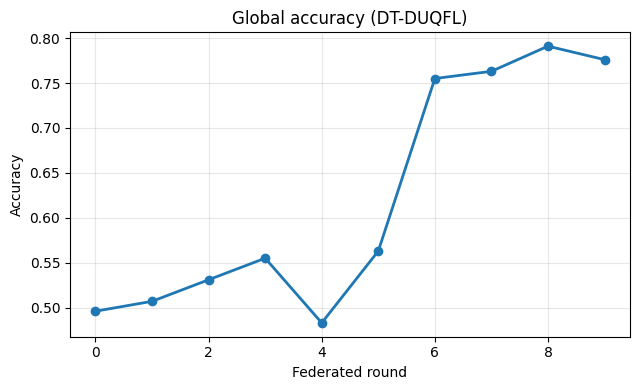

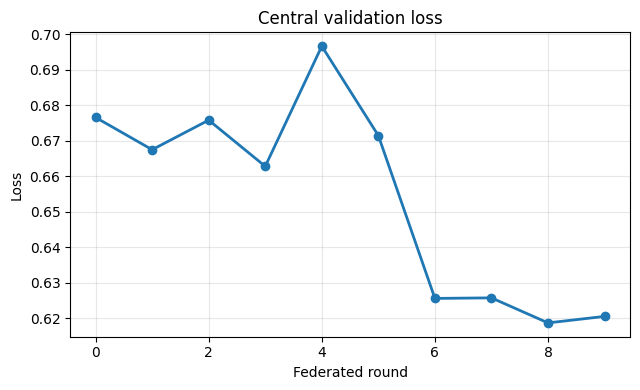

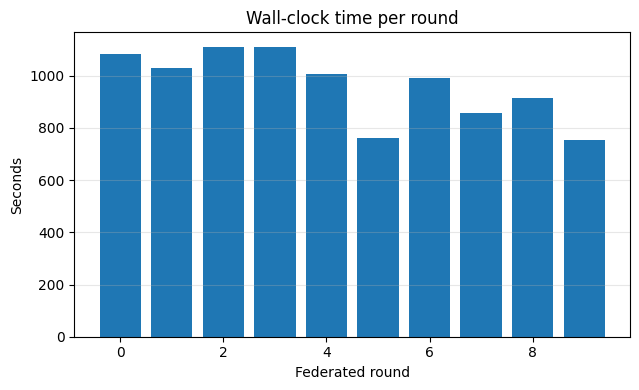

In [7]:
# quick visuals
rounds = list(range(len(global_acc)))
plot_accuracy_curve(rounds, global_acc, label="Global accuracy (DT-DUQFL)")
plot_val_loss(rounds, val_losses, label="Central validation loss")
plot_time_per_round(rounds, round_times)